In [28]:
import os
import pickle
import numpy as np
from auditory_cortex.dataloader import DataLoader
from auditory_cortex.spikes_dataset import SpikesData, Network, training_epoch, evaluation_epoch, get_dataloaders
from auditory_cortex import cache_dir
from auditory_cortex.utils import cc_norm
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex.plotters.plotter_utils import PlotterUtils
import auditory_cortex

import torch
import optuna
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


#### DB filename..

In [57]:
PRETRAINED = False
# MODEL_NAME = 'wave2letter_modified'
# LAYER_ID = 6
MODEL_NAME = 'wave2vec2'
LAYER_ID = 7
# MODEL_NAME = 'deepspeech2'
# LAYER_ID = 3
# MODEL_NAME = 'speech2text'
# LAYER_ID = 3


AREA = 'core'
# AREA = 'belt'

study_name = f"CNN_based_model_{AREA}"
if PRETRAINED:
    study_name = f"{MODEL_NAME}_l{LAYER_ID}_based_model_{AREA}"

# study_name = "CNN_based_model"
optuna_cache_dir = os.path.join(cache_dir, 'optuna')

abs_file_path = f"{os.path.join(optuna_cache_dir, study_name)}.db"

if os.path.exists(abs_file_path):
    storage_name = f"sqlite:///{os.path.join(optuna_cache_dir, study_name)}.db"
    print(storage_name)
else:
    print("Results not available for the combo..")

print(f"Creating optuna study...")
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction="maximize",
)

trial = study.best_trial

for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2023-11-19 23:14:28,459] Using an existing study with name 'CNN_based_model_core' instead of creating a new one.


sqlite:////scratch/gilbreth/ahmedb/cache/optuna/CNN_based_model_core.db
Creating optuna study...
    learning_rate: 0.0034302241168045608
    weight_decay: 0.00014929491635326078
    batch_size: 4
    num_layers: 4
    num_units_l0: 32
    kernel_size_l0: 7
    num_units_l1: 401
    kernel_size_l1: 3
    num_units_l2: 34
    kernel_size_l2: 5
    num_units_l3: 79
    kernel_size_l3: 7


In [27]:
if PRETRAINED:
    name_identifier = f'{MODEL_NAME}_layer_{LAYER_ID}_area_{AREA}'
else:
    name_identifier = f'CNN_area_{AREA}'


network_checkpoint = os.path.join(
        cache_dir, 'optuna', f'{name_identifier}.pth'
    )
if os.path.exists(network_checkpoint):
    print(f"Exists...")
else:
    print(f"Not found...!")

Not found...!


In [31]:
# os.remove(abs_file_path)

#### Evaluating models...

In [44]:
def test_model(
        PRETRAINED = True, MODEL_NAME = 'wave2vec2', 
        LAYER_ID = 7, AREA = 'core'
    ):
    study_name = f"CNN_based_model_{AREA}"
    if PRETRAINED:
        study_name = f"{MODEL_NAME}_l{LAYER_ID}_based_model_{AREA}"

    # study_name = "CNN_based_model"
    optuna_cache_dir = os.path.join(cache_dir, 'optuna')

    abs_file_path = f"{os.path.join(optuna_cache_dir, study_name)}.db"

    if os.path.exists(abs_file_path):
        storage_name = f"sqlite:///{os.path.join(optuna_cache_dir, study_name)}.db"

    print(f"Creating optuna study...")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True,
        direction="maximize",
    )

    trial = study.best_trial

    num_layers = trial.params['num_layers']
    num_units = []
    kernel_sizes = []
    for i in range(num_layers):
        num_units.append(trial.params[f"num_units_l{i}"])
        kernel_sizes.append(trial.params[f"kernel_size_l{i}"])

    if PRETRAINED:
        dataloader = DataLoader()
        pretrained_features = dataloader.get_DNN_layer_features(
                model_name=MODEL_NAME, layer_ID=LAYER_ID
            )
    else:
        pretrained_features = None

    test_data = SpikesData(
            test=True, pretrained=PRETRAINED,
            pretrained_features=pretrained_features, neural_area=AREA 
        ) 
    in_channels = test_data.feat_channels
    spike_channels = test_data.spike_channels

    model = Network(
        num_layers, num_units, kernel_sizes, in_channels, spike_channels
        )
    
    if PRETRAINED:
        name_identifier = f'{MODEL_NAME}_layer_{LAYER_ID}_area_{AREA}'
    else:
        name_identifier = f'CNN_area_{AREA}'

    network_checkpoint = os.path.join(
        cache_dir, 'optuna', f'{name_identifier}.pth'
    )

    # network_checkpoint = os.path.join(
    #         cache_dir, 'optuna', f'{MODEL_NAME}_layer_{LAYER_ID}_area_{AREA}.pth'
    #     )
    if os.path.exists(network_checkpoint):
        checkpoint = torch.load(network_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        raise FileNotFoundError(f"Checkpoint {network_checkpoint} not found.")

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(DEVICE)

    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size = len(test_data), shuffle=True, collate_fn=SpikesData.collate_fn
    )
    model.eval()
    with torch.no_grad():
        # Test loss (Needs to be minimized..)
        test_score = 0
        for feats, spikes in test_dataloader:
            feats = feats.to(DEVICE)
            spikes = spikes.to(DEVICE)
            predicted_spikes = model(feats)

            test_corr = cc_norm(predicted_spikes.squeeze().cpu().numpy(), spikes.squeeze().cpu().numpy())
            # test_corr =  correlations(predicted_spikes, spikes)
    return test_corr, model, test_data
    # return test_corr.cpu().numpy(), model, test_data

    
def correlations(Y_hat, Y):

    Y = Y.squeeze()
    Y_hat = Y_hat.squeeze()

    N = Y.shape[1]

    Y_std = torch.std(Y, dim=0)
    Y_hat_std = torch.std(Y_hat, dim=0)
    inners = torch.matmul((Y - torch.mean(Y, dim=0)).T, (Y_hat - torch.mean(Y_hat, dim=0)))/N
    corr = torch.diag(inners)/torch.sqrt(Y_std*Y_hat_std)
    corr = torch.clip(corr, min=0, max=1)

    return corr

def get_normalizers(dataloader, area, threshold):

    sig_sessions = dataloader.corr_obj.get_significant_sessions(threshold=threshold)
    sessions = dataloader.metadata.get_all_sessions(AREA)
    sig_sessions = sig_sessions[np.isin(sig_sessions, sessions)]
    normalizers = []
    total_channels = 0
    for session in sig_sessions:
        # keep only good channels...
        good_channels = np.array(
            dataloader.corr_obj.get_good_channels(session, threshold=threshold),
            dtype=np.uint32
            )
        for channel in good_channels:
            norm = dataloader.corr_obj.get_selected_data(
                sessions=[session], bin_width=20, delay=0, threshold=threshold,
                channel=channel
            ).head(1)['normalizer'].item()
            normalizers.append(norm)
    return np.array(normalizers)

    


# def bar_plot_with_model_colors(data_dict, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
#     means = []
#     x_coordinates = []
#     SEMs = []
#     colors = []
#     for model_name, layer_data in data_dict.items():
#         x_coordinates.append(model_name)
#         means.append(np.mean(layer_data))
#         SEMs.append(np.std(layer_data)/np.sqrt(10)) #number of sents in test set?
#         if model_name in auditory_cortex.model_names:
#             colors.append(PlotterUtils.get_model_specific_color(model_name))
#         else:
#             colors.append()
        
#     ax.bar(x=x_coordinates, height=means, yerr=SEMs,
#         color=colors)
#     return ax



In [45]:
uncorrected_scores_dict_core = {}
uncorrected_scores_dict_belt = {}

[I 2023-11-19 23:05:23,720] Using an existing study with name 'wave2vec2_l7_based_model_belt' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


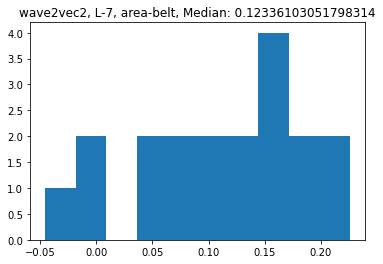

In [46]:
PRETRAINED = True

MODEL_NAME = 'wave2vec2'
LAYER_ID = 7
# AREA = 'core'
AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr)}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr

[I 2023-11-19 23:32:45,430] Using an existing study with name 'wave2vec2_l7_based_model_core' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


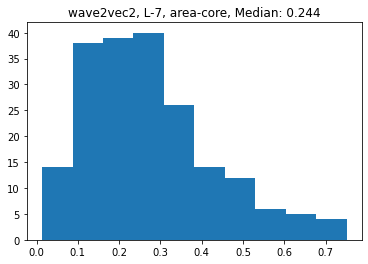

In [59]:
PRETRAINED = True

MODEL_NAME = 'wave2vec2'
LAYER_ID = 7
AREA = 'core'
# AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:33:56,148] Using an existing study with name 'wave2letter_modified_l6_based_model_core' instead of creating a new one.


Creating optuna study...


Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


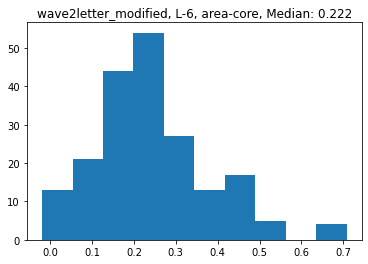

In [60]:
PRETRAINED = True

MODEL_NAME = 'wave2letter_modified'
LAYER_ID = 6
AREA = 'core'
# AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr

[I 2023-11-19 23:06:43,231] Using an existing study with name 'wave2letter_modified_l6_based_model_belt' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


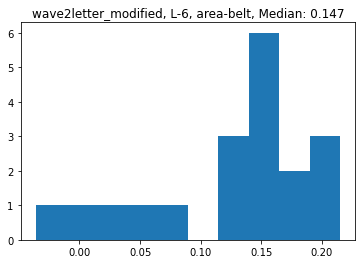

In [47]:
PRETRAINED = True

MODEL_NAME = 'wave2letter_modified'
LAYER_ID = 6
# AREA = 'core'
AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:34:12,253] Using an existing study with name 'deepspeech2_l3_based_model_core' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


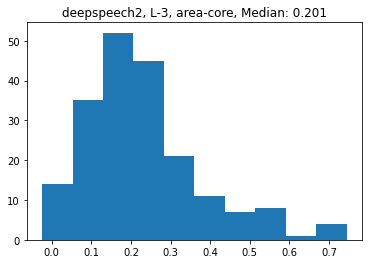

In [61]:
PRETRAINED = True

MODEL_NAME = 'deepspeech2'
LAYER_ID = 3
AREA = 'core'
# AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:07:00,140] Using an existing study with name 'deepspeech2_l3_based_model_belt' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


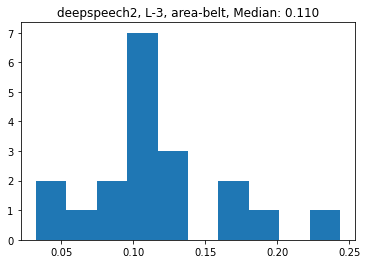

In [48]:
PRETRAINED = True

MODEL_NAME = 'deepspeech2'
LAYER_ID = 3
# AREA = 'core'
AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:34:31,857] Using an existing study with name 'speech2text_l3_based_model_core' instead of creating a new one.


Creating optuna study...


Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


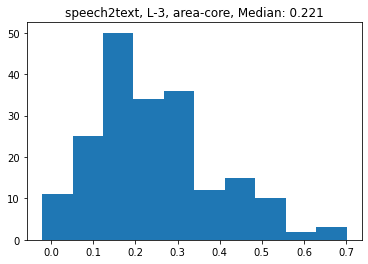

In [62]:
PRETRAINED = True

MODEL_NAME = 'speech2text'
LAYER_ID = 3
AREA = 'core'
# AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:07:20,711] Using an existing study with name 'speech2text_l3_based_model_belt' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.
Resamping ANN features at bin-width: 20
Reading existing dataframe.


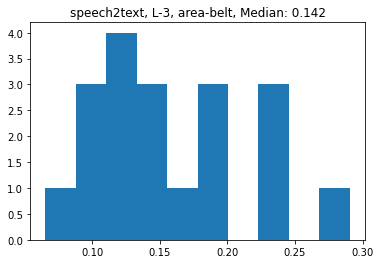

In [49]:
PRETRAINED = True

MODEL_NAME = 'speech2text'
LAYER_ID = 3
# AREA = 'core'
AREA = 'belt'

test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)
plt.hist(test_corr)
plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr):.3f}")
if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:31:58,642] Using an existing study with name 'CNN_based_model_core' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.


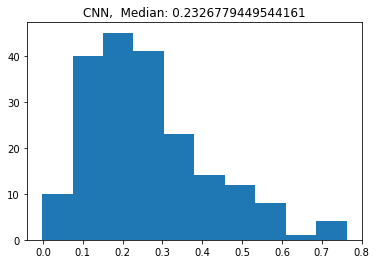

In [58]:
PRETRAINED = False

MODEL_NAME = 'CNN'
LAYER_ID = 7
AREA = 'core'
# AREA = 'belt'


test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)

plt.hist(test_corr)
if not PRETRAINED:
    MODEL_NAME = 'CNN'
    plt.title(f"{MODEL_NAME},  Median: {np.median(test_corr)}")
else:
    plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr)}")

if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


[I 2023-11-19 23:07:37,268] Using an existing study with name 'CNN_based_model_belt' instead of creating a new one.


Creating optuna study...
Reading existing dataframe.


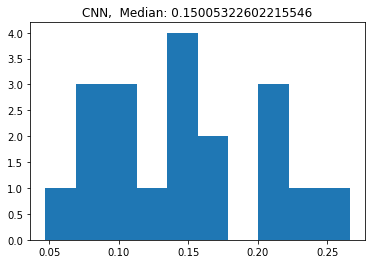

In [50]:
PRETRAINED = False

MODEL_NAME = 'CNN'
LAYER_ID = 7
# AREA = 'core'
AREA = 'belt'


test_corr, model, test_data = test_model(
    PRETRAINED, MODEL_NAME, LAYER_ID, AREA
)

plt.hist(test_corr)
if not PRETRAINED:
    MODEL_NAME = 'CNN'
    plt.title(f"{MODEL_NAME},  Median: {np.median(test_corr)}")
else:
    plt.title(f"{MODEL_NAME}, L-{LAYER_ID}, area-{AREA}, Median: {np.median(test_corr)}")

if AREA =='core':
    uncorrected_scores_dict_core[MODEL_NAME] = test_corr
else:
    uncorrected_scores_dict_belt[MODEL_NAME] = test_corr


In [26]:
test_corr.shape

(198,)

model_name 'CNN' not recognizable!!!


Text(0.5, 1.0, 'Uncorrected test correlations, core')

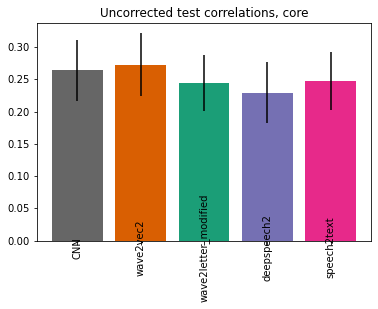

In [63]:
ax = RegPlotter.bar_plot_with_model_colors(uncorrected_scores_dict_core)
plt.xticks(rotation=90, va='center', ha='center')
ax.set_title("Uncorrected test correlations, core")

model_name 'CNN' not recognizable!!!


Text(0.5, 1.0, 'Uncorrected test correlations, belt')

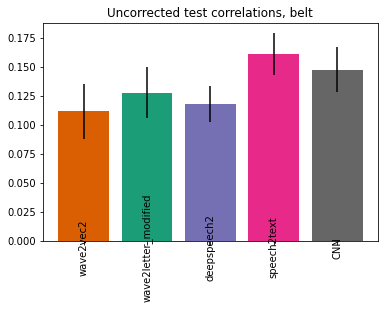

In [51]:
ax = RegPlotter.bar_plot_with_model_colors(uncorrected_scores_dict_belt)
plt.xticks(rotation=90, va='center', ha='center')
ax.set_title("Uncorrected test correlations, belt")

In [52]:
AREA = 'core'
threshold = 0.061
dataloader = DataLoader()
normalizer_dict = {}
normalizer_dict[AREA] = get_normalizers(
    dataloader, AREA, threshold 
)
AREA = 'belt'
normalizer_dict[AREA] = get_normalizers(
    dataloader, AREA, threshold 
)

Reading existing dataframe.


In [64]:
AREA = 'core'
corrected_scores_dict_core = {}
for key, value in uncorrected_scores_dict_core.items():
    corrected_scores_dict_core[key] =  value / np.sqrt(normalizer_dict[AREA])

AREA = 'belt'
corrected_scores_dict_belt = {}
for key, value in uncorrected_scores_dict_belt.items():
    corrected_scores_dict_belt[key] =  value / np.sqrt(normalizer_dict[AREA])


model_name 'CNN' not recognizable!!!


Text(0.5, 1.0, 'Corrected test correlations, core')

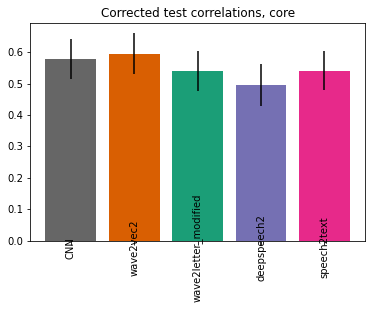

In [65]:
ax = RegPlotter.bar_plot_with_model_colors(corrected_scores_dict_core)
plt.xticks(rotation=90, va='center', ha='center')
ax.set_title("Corrected test correlations, core")

model_name 'CNN' not recognizable!!!


Text(0.5, 1.0, 'corrected test correlations, belt')

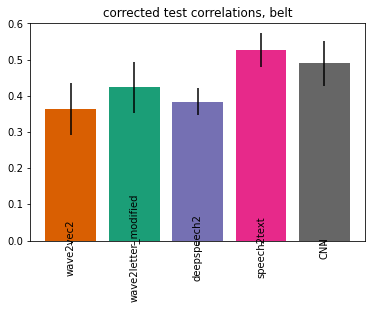

In [55]:
ax = RegPlotter.bar_plot_with_model_colors(corrected_scores_dict_belt)
plt.xticks(rotation=90, va='center', ha='center')
ax.set_title("corrected test correlations, belt")

#### CNN direct..

In [ ]:
SPIKE_CHANNELS = 217
SPECT_CHANNELS = 128
EPOCHS = 100
BATCH_SIZE = 32

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Network(2, [256, 256], [5,3], SPECT_CHANNELS, SPIKE_CHANNELS).to(DEVICE)
train_dataloader, test_dataloader = get_dataloaders(BATCH_SIZE)

learning_rate = 1e-3
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_history = []
test_loss_history = []
for epoch in range(EPOCHS):
    # training_loss = 0
    print(f"{epoch+1}/{EPOCHS}:", end='')

    training_loss = training_epoch(
        model, optimizer, train_dataloader, DEVICE)

    print(f"train_loss: {training_loss}, ", end='')
    train_loss_history.append(training_loss)

    # # Evaluate performace...
    # if (epoch+1) % 1==0:
    test_loss = evaluation_epoch(
        model, test_dataloader, DEVICE
        )
    print(f"test_loss: {test_loss}, ")
    test_loss_history.append(test_loss)


#### saving model...

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import argparse

from auditory_cortex.spikes_dataset import SpikesData, Network, training_epoch, evaluation_epoch, get_dataloaders
from auditory_cortex import cache_dir

SPIKE_CHANNELS = 217
SPECT_CHANNELS = 128
EPOCHS = 25


# BATCH_SIZE = 32

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def create_network(trial, in_channels, spike_channels):
    
    num_layers = trial.suggest_int("num_layers", 1, 7)

    layers = []
    num_units = []
    kernel_sizes = []
    for i in range(num_layers):
        num_units.append(trial.suggest_int(f"num_units_l{i}", 32, 512, log=True))
        kernel_sizes.append(trial.suggest_int(f"kernel_size_l{i}", 3, 9, step=2))

    model = Network(
        num_layers, num_units, kernel_sizes, in_channels, spike_channels
        )
    return model


def train_and_save(trial):

    batch_size = trial['batch_size']
    learning_rate = trial['learning_rate']
    weight_decay = trial['weight_decay']

    # get dataloaders...
    train_dataloader, test_dataloader, feat_channels = get_dataloaders(
        batch_size, pretrained=PRETRAINED, model_name=MODEL_NAME, layer_ID=LAYER_ID,
        neural_area=AREA
    )

    num_layers = trial['num_layers']

    layers = []
    num_units = []
    kernel_sizes = []
    for i in range(num_layers):
        num_units.append(trial[f"num_units_l{i}"])
        kernel_sizes.append(trial[f"kernel_size_l{i}"])

    model = Network(
        num_layers, num_units, kernel_sizes, feat_channels, SPIKE_CHANNELS
        ).to(device=DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss_history = []
    val_loss_history = []
    for epoch in range(EPOCHS):
        # training_loss = 0
        print(f"{epoch+1}/{EPOCHS}:")

        training_loss = training_epoch(
            model, optimizer, train_dataloader, DEVICE)
        train_loss_history.append(training_loss)
        # Evaluate performace...
        test_score = evaluation_epoch(
                model, test_dataloader, DEVICE
            )
        
        val_loss_history.append(test_score)

        # trial.report(test_score, epoch)
        # if trial.should_prune:
            # assert False, "should_prune() should always return False with this pruner."
            
            #  raise optuna.exceptions.TrialPruned()
    losses = {
        'training': train_loss_history,
        'validation': val_loss_history 
    }

    network_checkpoint = os.path.join(
        cache_dir, 'optuna', f'{MODEL_NAME}_layer_{LAYER_ID}', f'_area_{AREA}.pth'
    )
    losses_filename = os.path.join(
        cache_dir, 'optuna', f'{MODEL_NAME}_layer_{LAYER_ID}', f'_area_{AREA}', 'losses.pkl'
    )

    with open(losses_filename, 'wb') as fout:
        pickle.dump(losses, fout)

    save_checkpoint(model, optimizer, EPOCHS, network_checkpoint)
    return test_score


def save_checkpoint(model, optimizer, epoch, PATH):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }

    torch.save(checkpoint, PATH)


# ------------------  get parser ----------------------#

def get_parser():
    # create an instance of argument parser
    parser = argparse.ArgumentParser(
        description='This is to compute and save the normalizer '+
            'for the sessions of neural data.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
        )

        # add arguments to read from command line
    parser.add_argument(
        '-m', '--model_name', dest='model_name', action='store',#  dest='model_name', required=True,
        choices=['wave2letter_modified', 'wave2vec2', 'speech2text', 'deepspeech2',
                'whisper_tiny', 'whisper_small', 'whisper_base', 'whisper_medium'],
        default='wave2vec2', 
        help='model to be used for RSA analysis.'
    )
    parser.add_argument(
        '-a','--neural_area', dest='neural_area', action='store_true', default='all',
        choices=['core', 'belt', 'all']
        help="Choose bin_width for normalizers."
    )

    parser.add_argument(
        '-p','--pretrained', dest='pretrained', action='store_true', default=False,
        help="Choose bin_width for normalizers."
    )
    parser.add_argument(
        '-l','--layer', dest='layer_ID', action='store', type=int, default=7,
        help="layer ID of Neural areas."
    )
    return parser

def run_study(args):
    # pretrained = True
    # model_name = 'wave2vec2'
    # layer_ID = 7
    global PRETRAINED
    global MODEL_NAME
    global LAYER_ID
    global AREA

    PRETRAINED = args.pretrained
    MODEL_NAME = args.model_name
    LAYER_ID = args.layer_ID
    AREA = args.area


    study_name = f"CNN_based_model_{AREA}"
    if PRETRAINED:
        study_name = f"{MODEL_NAME}_l{LAYER_ID}_based_model_{AREA}"

    optuna_cache_dir = os.path.join(cache_dir, 'optuna')
    if not os.path.exists(optuna_cache_dir):
        os.makedirs(optuna_cache_dir)
        print(f"Optuna cache dir created.")

    storage_name = f"sqlite:///{os.path.join(optuna_cache_dir, study_name)}.db"

    print(f"Creating optuna study...")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True,
        direction="maximize",
        # sampler=optuna.TPESampler(n_startup_trials=25, multivariate=True, seed=123),
        # pruner=optuna.pruners.NopPruner(),
        # pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource='auto',
        #         reduction_factor=4, min_early_stopping_rate=4
        #     ),
        # pruner=optuna.pruners.MedianPruner(
        #     n_startup_trials=5, n_warmup_steps=10, interval_steps=2,
        #     n_min_trials = 5
        # )  
    )

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    train_and_save(trial)



if __name__ == "__main__":

    start_time = time.time()
    parser = get_parser()
    args = parser.parse_args()

    # display the arguments passed
    for arg in vars(args):
        print(f"{arg:15} : {getattr(args, arg)}")

    run_study(args)
    elapsed_time = time.time() - start_time
    print(f"It took {elapsed_time/60:.1f} min. to run.")


#### Using pretrained w2v2

In [2]:

dataloader = DataLoader()

Reading existing dataframe.


In [3]:
feats = dataloader.get_DNN_layer_features("wave2vec2", 7)

Resamping ANN features at bin-width: 20


In [9]:
out = next(iter(feats.values()))

In [10]:
out

array([[-0.11490692, -0.31417865, -0.20332897, ...,  0.30730438,
         0.06202218,  0.5165188 ],
       [-0.00848724, -0.2573662 , -0.02639392, ...,  0.07734188,
         0.1576763 ,  0.12543337],
       [ 0.04541423, -0.1392012 , -0.15199772, ..., -0.08024155,
         0.15812479,  0.15192534],
       ...,
       [ 0.01544156,  0.12005015, -0.15437998, ..., -0.1014753 ,
        -0.12161605,  0.34275883],
       [-0.37257138,  0.28031945, -0.09344246, ..., -0.21024844,
         0.01860132,  0.13655695],
       [-0.20667167, -0.01455435, -0.03940091, ...,  0.03562726,
        -0.25240362,  0.2758299 ]], dtype=float32)

In [6]:
feats[12].shape

(69, 768)

In [2]:
data = SpikesData(pretrained=True)

dataloader = torch.utils.data.DataLoader(
    data, batch_size = 4, shuffle=True, collate_fn=SpikesData.collate_fn
)

Reading existing dataframe.
Resamping ANN features at bin-width: 20


In [3]:
len(data)

479

In [4]:
data.feat_channels

768

In [5]:
spect, spikes = data[0]

In [6]:
spect.shape

(75, 768)

In [7]:
spikes.shape

torch.Size([75, 217])

In [6]:
len(data)

10

In [6]:
class Network(nn.Module):

    def __init__(
            self, num_layers, num_units, kernel_sizes,
            in_channels, out_channels
        ):
        super(Network, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels=num_units[i],
                                kernel_size=kernel_sizes[i], padding='same'))
            layers.append(nn.ReLU())
            in_channels = num_units[i]

        self.conv_layers = nn.Sequential(*layers)
        self.linear = nn.Linear(in_channels, out_channels)
        self.out_channels = out_channels

    def forward(self, x):
        x = x.transpose(1,0) 
        x = self.conv_layers(x)     

        # x = x.view(-1, x.shape[0]) 
        x = x.transpose(1,0)  

        x = self.linear(x)
        out = F.relu(x)
        return out

In [7]:
spike_channels = 217
in_channels = 128
model = Network(2, [512,512], [5,5], 128, 217)

In [8]:
spect, spikes = next(iter(dataloader))
spect.shape

torch.Size([445, 128])

In [9]:
out = model(spect)

In [10]:
out.shape

torch.Size([445, 217])

In [13]:
study_name = "CNN_based_model"
optuna_cache_dir = os.path.join(cache_dir, 'optuna')

storage_name = f"sqlite:///{os.path.join(optuna_cache_dir, study_name)}.db"

In [2]:
study_name = "CNN_based_model"
optuna_cache_dir = os.path.join(cache_dir, 'optuna')

storage_name = f"{os.path.join(optuna_cache_dir, study_name)}.db"

In [8]:
PRETRAINED = True
MODEL_NAME = 'wave2vec2'
LAYER_ID = 7
STUDY_NAME = "CNN_based_model"
if PRETRAINED:
    STUDY_NAME = f"{MODEL_NAME}_l{LAYER_ID}_based_model"

storage_name = f"{os.path.join(optuna_cache_dir, study_name)}.db"
storage_name

NameError: name 'optuna_cache_dir' is not defined

In [4]:
# os.remove(storage_name)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gilbreth/ahmedb/cache/optuna/CNN_based_model.db'

In [19]:
storage_name

'/scratch/gilbreth/ahmedb/cache/optuna/CNN_based_model.db'

In [11]:
spikes.shape

torch.Size([445, 217])